In [1]:
# author: Behrad Soleimani <behrad@umd.edu>

import numpy as np
import scipy
from scipy import linalg
 
import nlgc
from nlgc._nlgc import _gc_extraction
# from simulation import missed_false_detection

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import mne

In [2]:
def data_generation(seed=0):
    np.random.seed(seed)
    
    n_eigenmodes = 1
    n = 100 # number of sensors
    
    n_patches = 50
    m = n_patches*n_eigenmodes # number of sources
    m_active = 20*n_eigenmodes 
    
    p, t = 2, 500 # order, time pts
    # 4*4*1  x*1000
    # 168*168*2 155*60*50
    q = 0.01*np.eye(m)

    a = np.zeros(p * m * m, dtype=np.float64)
    a.shape = (p, m, m)

    for i in range(m_active):
        q[i, i] = 1
        a[0, i, i] = 0.9
        
        
    n_links = m_active//2
    # (i,j) pairs to add a link to
    for i, j in zip(np.random.randint(0, m_active, n_links), 
                    np.random.randint(0, m_active, n_links)):
        # (i,j) pair has a random link nature
        a[0, i, j] = np.random.uniform(-0.5, 0.5)
        a[1, i, j] = np.random.uniform(-0.5, 0.5)

    temp_JG = np.sum(np.abs(a), axis=0)
    JG = temp_JG != 0
    np.fill_diagonal(JG, 0)
    JG_ = JG.copy()
    JG = np.zeros((n_patches, n_patches))
    for ei in range(n_eigenmodes):
        for ej in range(n_eigenmodes):
            JG += JG_[ei::n_eigenmodes, ej::n_eigenmodes]

    u = np.random.standard_normal(m * t)
    u.shape = (t, m)
    
    l = linalg.cholesky(q, lower=True)
    u = u.dot(l.T)
    
    # added artificial data filtering
#     deltasos = scipy.signal.butter(25, [0.1, 4], 'bp', fs=100, output='sos')
#     betasos = scipy.signal.butter(25, [4, 8], 'bp', fs=100, output='sos')
    
    x = np.empty((t, m), dtype=np.float64)
    for i in range(p):
        x[i] = 0.0
        
#     if band == 'delta':
# #         filt = mne.filter.filter_data(u.T, sfreq=100, l_freq=0.1, h_freq=4, phase='minimum').T
#         filt = scipy.signal.sosfilt(deltasos, u.T).T
#     if band == 'beta':
# #         filt = mne.filter.filter_data(u.T, sfreq=100, l_freq=13, h_freq=25, phase='minimum').T
#         filt = scipy.signal.sosfilt(betasos, u.T).T
    filt = u
        
    for i in range(p, t):
        x[i] = filt[i]
#         if band == 'delta':
#             x[i] = scipy.signal.sosfilt(deltasos, u.T).T[i]
#         if band == 'beta':
#             x[i] = scipy.signal.sosfilt(betasos, u.T).T[i]
            
    x_temp1 = np.copy(x.T)

    for i in range(p, t):
        x[i] = filt[i]
#         if band == 'delta':
#             x[i] = scipy.signal.sosfilt(deltasos, u.T).T[i]
#         if band == 'beta':
#             x[i] = scipy.signal.sosfilt(betasos, u.T).T[i]
            
        # insert unhidden links
        for k in range(p):
            x[i] += a[k].dot(x[i - k - 1])
            
    
    # insert hidden links for delta band only
    # this means that some streams that were 0 previously will
    # be set nonzero, but the gc links are to the delta-filtered 
    # beta band envelope
#     print(x.T.shape)
#     for i in range(x.T.shape[0]):
#         plt.psd(x.T[i])
#     plt.show()
    
#     x_temp2 = np.copy(x.T)
    
#     if band == 'delta':
#         hidden_a = np.zeros(p * m * m, dtype=np.float64)
#         hidden_a.shape = (p, m, m)

#         for i in range(m_active):
#             hidden_a[0, i, i] = 0.9
        
        # 5 -> 2 hidden
#         hidden_a[0, 5, 3] = -0.5
            
#         betafiltered = scipy.signal.sosfilt(betasos, u.T)
#         betafiltered = mne.filter.filter_data(u.T, sfreq=100, l_freq=13, h_freq=25, phase='minimum')
    
        # beta band envelope
#         betaenv = np.abs(scipy.signal.hilbert(betafiltered))  
        
        # delta band of beta band envelope
#         dbenv = scipy.signal.sosfilt(deltasos, betaenv).T # delta band of beta band envelope
#         dbenv = mne.filter.filter_data(betaenv, sfreq=100, l_freq=0.1, h_freq=4, phase='minimum').T
        
        # set the delta-filtered beta band envelope to be predicted by the delta band sources
#         for i in range(p, t):
#             # insert hidden links
#             for k in range(p):
#                 # past deltaband predicts future d-b envelope
#                 x[i - k - 1] += hidden_a[k].dot(dbenv[i])
                
#     for i in range(x.T.shape[0]):
#         plt.psd(x.T[i])
#     plt.show()
    
#     for i in range(x.T.shape[0]):
#         print(np.isclose(x_temp1[i], x_temp2[i]).sum())
#     print()
#     for i in range(x.T.shape[0]):
#         print(np.isclose(x_temp2[i], x.T[i]).sum())
        
        
    pow_actives = []
    for i in range(m):
        pow_actives.append(np.mean(x[:, i]**2))

    f = np.random.randn(n, m)
    f /= np.sqrt(np.sum(f ** 2, axis=0))

    y = x.dot(f.T)
    px = y.dot(y.T).trace()

    noise = np.random.standard_normal(y.shape)
#     noise = np.random.normal(0, 5, y.shape)
#     print("noise", noise.shape)
#     if band == 'delta':
# #         noise = mne.filter.filter_data(noise.T, sfreq=100, l_freq=0.1, h_freq=4, phase='minimum').T
#         noise = scipy.signal.sosfilt(deltasos, noise.T).T
#     if band == 'beta':
# #         noise = mne.filter.filter_data(noise.T, sfreq=100, l_freq=13, h_freq=25, phase='minimum').T
#         noise = scipy.signal.sosfilt(betasos, noise.T).T

#     print('noise', noise.shape)
#     for i in range(noise.T.shape[0]):
#         plt.psd(noise.T[i])
#     plt.show()
    pn = noise.dot(noise.T).trace()
    multiplier = 1e2 * pn / px

    y += noise / np.sqrt(multiplier)
    r_cov = 1 / multiplier

    return f, y, r_cov, p, JG, pow_actives, a

In [3]:
def nlgc_map_opt(M, G, r, order, self_history=None, var_thr=1.0, n_segments=1, lambda_range=None, max_iter=500,
                 max_cyclic_iter=3, tol=1e-5, sparsity_factor=0.0, cv=5):
    n_eigenmodes = 1
    n, nnx = G.shape
    len_patch_idx = nnx // n_eigenmodes
    _, t = M.shape
    tt = t // n_segments

    d_raw = np.zeros((n_segments, len_patch_idx, len_patch_idx))
    bias_r = np.zeros((n_segments, len_patch_idx, len_patch_idx))
    bias_f = np.zeros((n_segments, 1))
    conv_flag = np.zeros((n_segments, len_patch_idx, len_patch_idx))
    models = []

    for n in range(0, n_segments):
        print('Segment: ', n + 1)
        print(lambda_range)
        d_raw_, bias_r_, bias_f_, model_f, conv_flag_ = \
            _gc_extraction(M[:, n * tt: (n + 1) * tt], G, r, p=order, p1=self_history, n_eigenmodes=n_eigenmodes,
                           ROIs=list(range(m)), cv=cv, lambda_range=lambda_range, max_iter=max_iter,
                           max_cyclic_iter=max_cyclic_iter, tol=tol, sparsity_factor=sparsity_factor,
                           use_lapack=True, use_es=True, var_thr=var_thr)
        d_raw[n] = d_raw_
        bias_r[n] = bias_r_
        bias_f[n] = bias_f_
        models.append(model_f)
        conv_flag[n] = conv_flag_

    nlgc_obj = nlgc.NLGC('Simulation_rnd', len_patch_idx, n, t, order, n_eigenmodes, n_segments, d_raw, bias_f, bias_r,
                         models, conv_flag, [], [])

    return nlgc_obj

In [4]:
np.random.seed(1)

# lambda_range = np.asanyarray(list(range(5, 105, 5)))/100
# lambda_range = [0.001, 0.025, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4]
lambda_range = [0.01, 0.05, 0.3]
# lambda_range = [0.001]
# 2*84*84*4 155*3000
max_iter = 500
max_cyclic_iter = 3
tol = 1e-5
sparsity_factor = 0.0
n_segments = 1
var_thr = 1.0
n_eigenmodes = 1

while True:
    try:
        f, y, r_cov, p, JG, pow_actives, _ = data_generation(seed=12)
        _, m = f.shape
        m = m//n_eigenmodes
        # f += 0.05*np.random.randn(f.shape[0], f.shape[1])
        # u @ np.diag(s) @ vh
        # u, s, vh = np.linalg.svd(f, full_matrices=False)
        
#         deltasos = scipy.signal.butter(25, [0.1, 4], 'bp', fs=100, output='sos')
#         betasos = scipy.signal.butter(25, [4, 8], 'bp', fs=100, output='sos')
    
#         if band == 'delta':
# #             y = mne.filter.filter_data(y.T, sfreq=100, l_freq=0.1, h_freq=4, phase='minimum').T
#             y = scipy.signal.sosfilt(deltasos, y.T).T
#         if band == 'beta':
# #             y = mne.filter.filter_data(y.T, sfreq=100, l_freq=13, h_freq=25, phase='minimum').T
#             y = scipy.signal.sosfilt(betasos, y.T).T
            
        temp_obj = nlgc_map_opt(y.T, f, r=r_cov, order=p, self_history=p, lambda_range=lambda_range, n_segments=n_segments,
                                var_thr=var_thr, max_iter=max_iter, max_cyclic_iter=max_cyclic_iter, tol=tol,
                                sparsity_factor=sparsity_factor)

        J = temp_obj.get_J_statistics(alpha=0.1)

#             msd_det, fls_det = missed_false_detection(JG, J)
#             print('################################################################')
#             print('missed: ', msd_det / np.sum(JG))
#             print('false : ', fls_det / (m * (m - 1) - np.sum(JG)))
#             print('################################################################')
#             np.set_printoptions(precision=2)
        break
    except ValueError as err:
        print('handling ValueError!', err)
    except np.linalg.LinAlgError as err:
        print('handling LinAlgError!', err)
    except RuntimeError as err:
        print('handling RuntimeError!', err)

# c_N = np.sum(temp_obj._model_f[0]._parameters[4]**2)
# for m in range(4):
#     print(np.sum(temp_obj._model_f[0]._parameters[4][:,m]**2)/c_N*100)
# #
# # for m in range(3):
# #     aF = np.sum(temp_obj._model_f[0]._parameters[0][0][m]**2)
# #     print(aF / (1-aF))
#
# print(temp_obj._model_f[0]._parameters[0][0])
# print(np.diag(temp_obj._model_f[0]._parameters[0][0]))
print("done")

Segment:  1
[0.01, 0.05, 0.3]
Start Ada CV...
iter:0, range:[0.01, 0.05, 0.3]
Starting cross-validation


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.1min
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:  1.5min remaining:   59.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.6min finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Done cross-validation
best_regularizing parameter: 0.05 using es
curr_lambda:0.3
iter:1, range:[0.175 0.425]
Starting cross-validation


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   31.7s remaining:   47.5s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:   33.6s remaining:   22.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   35.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   35.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Done cross-validation
best_regularizing parameter: 0.175 using es
curr_lambda:0.175
iter:2, range:[0.1125 0.2375]
Starting cross-validation


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   38.2s remaining:   57.2s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:   40.0s remaining:   26.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   43.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   43.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Done cross-validation
best_regularizing parameter: 0.11249999999999996 using es
curr_lambda:0.175
iter:3, range:[0.14375 0.20625]
Starting cross-validation


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   39.7s remaining:   59.6s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:   43.2s remaining:   28.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   46.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   46.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Done cross-validation
best_regularizing parameter: 0.14375 using es
curr_lambda:0.20625
iter:4, range:[0.190625 0.221875]
Starting cross-validation


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   47.4s remaining:  1.2min
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:   51.2s remaining:   34.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   54.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   54.1s finished


Done cross-validation
best_regularizing parameter: 0.22187499999999996 using es
Checking 22 links...


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   4 out of  22 | elapsed:   10.1s remaining:   45.3s
[Parallel(n_jobs=20)]: Done   7 out of  22 | elapsed:   10.2s remaining:   21.8s
[Parallel(n_jobs=20)]: Done  10 out of  22 | elapsed:   10.2s remaining:   12.3s
[Parallel(n_jobs=20)]: Done  13 out of  22 | elapsed:   10.3s remaining:    7.1s


done


[Parallel(n_jobs=20)]: Done  16 out of  22 | elapsed:   10.3s remaining:    3.9s
[Parallel(n_jobs=20)]: Done  19 out of  22 | elapsed:   10.3s remaining:    1.6s
[Parallel(n_jobs=20)]: Done  22 out of  22 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  22 out of  22 | elapsed:   10.4s finished


1
1


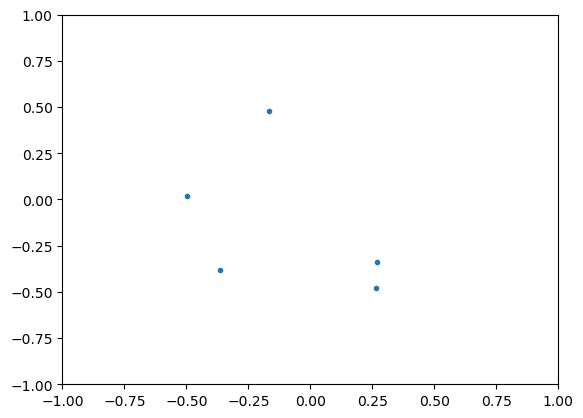

(-1.0, 1.0)

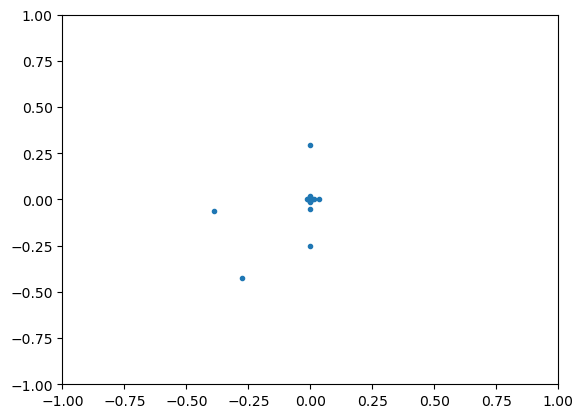

In [5]:
a1s = []
a2s = []
b1s = []
b2s = []

f, y, r_cov, p, JG, pow_actives, a_true = data_generation(seed=12)
A = a_true
neigs = 1
order = A.shape[0]
assert(order == 2) 
print(neigs)

partition=None
factor=0.1

link_natures = np.zeros((A.shape[1]//neigs, A.shape[2]//neigs, neigs, neigs, 2))
for ej in range(neigs):
    for ei in range(neigs):
        for orderno in range(order):
            link_natures[..., ei, ej, orderno] = A[orderno][ei::neigs, ej::neigs]  
            if not partition is None:
                link_natures = blank_natures_partition(link_natures, partition)

for ej in range(neigs):
    for ei in range(neigs):
        row, col = np.where(temp_obj.get_J_statistics() >= factor)

        # if we want to look at all link natures, not just significant GC links,
        # we have to exclude the B coefficients (diagonal of A matrix)
        if factor == 0.0:
            row, col = np.where(~np.eye(A.shape[1]//neigs, A.shape[2]//neigs, dtype=bool))
        a1s.extend((link_natures[..., ei, ej, 0] * (temp_obj.get_J_statistics() >= factor))[row, col])
        a2s.extend((link_natures[..., ei, ej, 1] * (temp_obj.get_J_statistics() >= factor))[row, col])

        # B coefficients are on diagonal of A matrix
        row, col = np.where(np.eye(A.shape[1]//neigs, A.shape[2]//neigs, dtype=bool))
        b1s.extend((link_natures[..., ei, ej, 0])[row, col])
        b2s.extend((link_natures[..., ei, ej, 1])[row, col])
        
plt.plot(a1s, a2s, '.')
a1s = []
a2s = []
b1s = []
b2s = []

A = temp_obj._model_f[0]._parameters[0]
neigs = 1
order = A.shape[0]
assert(order == 2) 
print(neigs)

partition=None
factor=0

link_natures = np.zeros((A.shape[1]//neigs, A.shape[2]//neigs, neigs, neigs, 2))
for ej in range(neigs):
    for ei in range(neigs):
        for orderno in range(order):
            link_natures[..., ei, ej, orderno] = A[orderno][ei::neigs, ej::neigs]  
            if not partition is None:
                link_natures = blank_natures_partition(link_natures, partition)

for ej in range(neigs):
    for ei in range(neigs):
        row, col = np.where(temp_obj.get_J_statistics() >= factor)

        # if we want to look at all link natures, not just significant GC links,
        # we have to exclude the B coefficients (diagonal of A matrix)
        if factor == 0.0:
            row, col = np.where(~np.eye(A.shape[1]//neigs, A.shape[2]//neigs, dtype=bool))
        a1s.extend((link_natures[..., ei, ej, 0] * (temp_obj.get_J_statistics() >= factor))[row, col])
        a2s.extend((link_natures[..., ei, ej, 1] * (temp_obj.get_J_statistics() >= factor))[row, col])

        # B coefficients are on diagonal of A matrix
        row, col = np.where(np.eye(A.shape[1]//neigs, A.shape[2]//neigs, dtype=bool))
        b1s.extend((link_natures[..., ei, ej, 0])[row, col])
        b2s.extend((link_natures[..., ei, ej, 1])[row, col])
        
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

plt.plot(a1s, a2s, '.')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
# # plt.xlim(-0.2, 0.2)
# # plt.ylim(-0.2, 0.2)
# # plt.plot(b1s, b2s, '.')

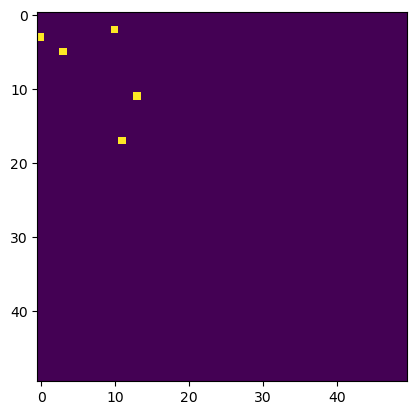

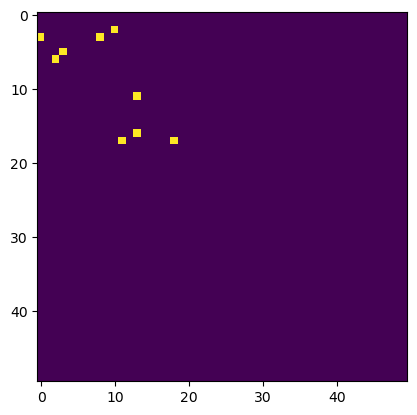

In [6]:
plt.imshow(J)
plt.show()
plt.imshow(JG)

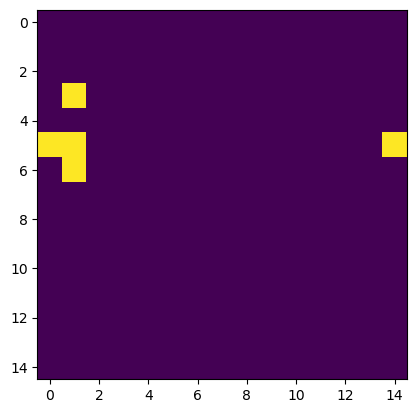

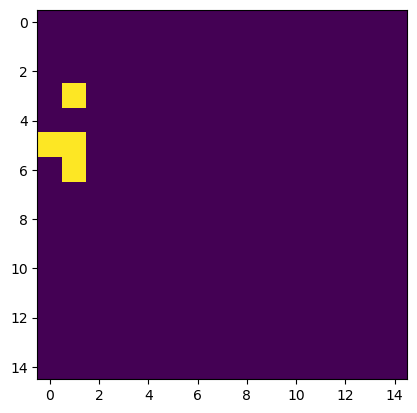

In [11]:
plt.imshow(J)
plt.show()
plt.imshow(JG)

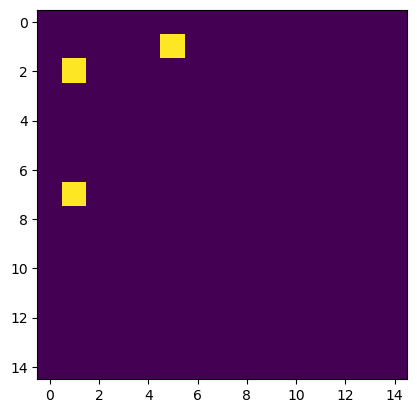

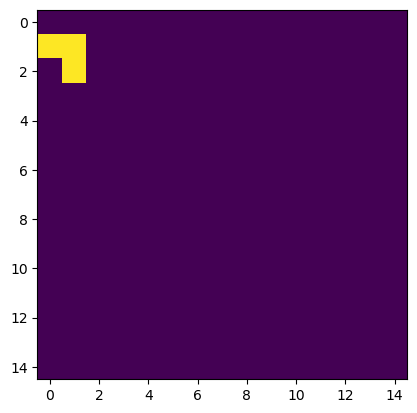

In [5]:
plt.imshow(J)
plt.show()
plt.imshow(JG)

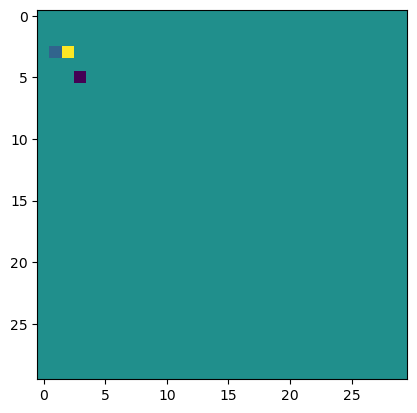

In [65]:
plt.imshow(a_true[0]*a_true[1])

In [35]:
f, y, r_cov, p, JG, pow_actives, a_true = data_generation(seed=12)

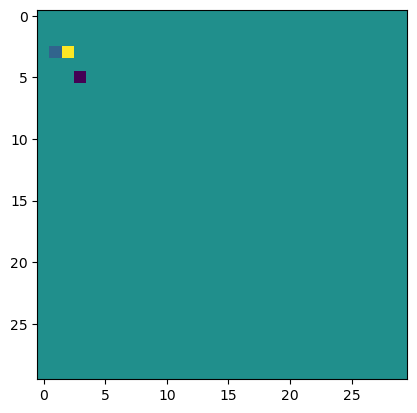

In [12]:
plt.imshow(a_true[0]*a_true[1])

In [13]:
a_true.shape

(2, 30, 30)

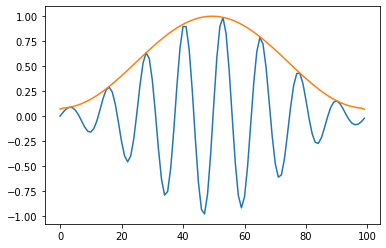

In [154]:
x = np.sin(np.linspace(0,50,100)) * np.hamming(100)
plt.plot(x)
env = np.abs(scipy.signal.hilbert(x))
plt.plot(env)

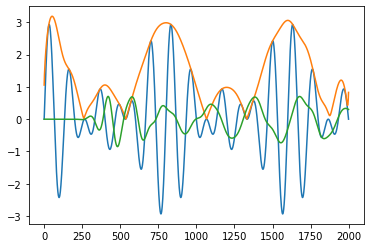

In [306]:
x = np.linspace(0, 5*np.pi, 2000)
# d = np.sin(3*x) * (list(np.zeros(125)) + list(np.hamming(250)) + list(np.zeros(125)))
# denv = np.abs(scipy.signal.hilbert(d))
b = np.sin(5*x) + np.sin(6*x) + np.sin(7*x)
benv = np.abs(scipy.signal.hilbert(b))

# plt.plot(d)
# plt.plot(denv)
plt.plot(b)
plt.plot(benv)

deltasos = scipy.signal.butter(25, [1, 5], 'bp', fs=400, output='sos')
benvdelta = scipy.signal.sosfilt(deltasos, benv)
plt.plot(benvdelta)

plt.show()

# plt.psd(d)
# plt.psd(denv)
# plt.psd(b*denv)
# plt.show()

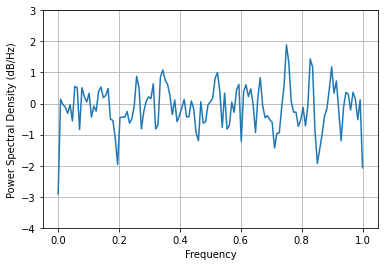

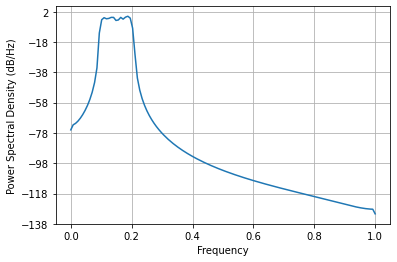

In [172]:
x = np.random.normal(0, 1, 10000)
xenv = np.abs(scipy.signal.hilbert(x))

sos = scipy.signal.butter(100, [50, 100], 'bp', fs=1000, output='sos')
filtered = scipy.signal.sosfilt(sos, xenv)

plt.psd(x)
plt.show()
plt.psd(filtered)
plt.show()
# plt.plot(x)
# env = np.abs(scipy.signal.hilbert(x))
# plt.plot(env)

(30, 1000)


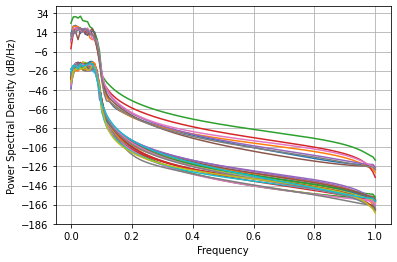

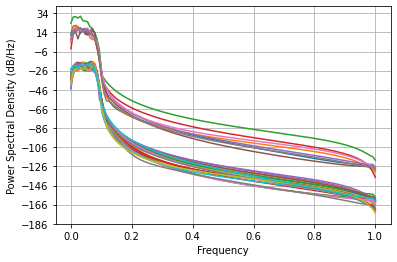

1000
1000
1000
1000
1000
25
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
[[[ 0.9  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0. ]
  [ 0.   0.9  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0. ]
  [ 0.   0.   0.9  0.   0.   0.   0.  -0.5  0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0. ]
  [ 0.   0.   0.   0.9  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0. ]
  [ 0.   0.   0.   0.   0.9  0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0. ]
  [ 0.   0.   0.   0.   0.   0.9  0.   0.   0.   0.   0.   0. 

(array([[ 0.03673474,  0.02868662,  0.05167218, ..., -0.19403187,
          0.09664351,  0.14209046],
        [-0.14579563,  0.0313774 ,  0.13243135, ..., -0.03431786,
          0.00301814,  0.04336367],
        [-0.14549275, -0.07757423, -0.09574163, ...,  0.0900745 ,
          0.06145707,  0.03296642],
        ...,
        [-0.10190612,  0.04233136,  0.01983142, ..., -0.06084205,
         -0.10563698, -0.1775283 ],
        [-0.02850655, -0.00885272,  0.01569078, ..., -0.02578282,
          0.00353405, -0.04094939],
        [ 0.04846911, -0.17009482, -0.00881734, ...,  0.0097676 ,
          0.0255532 ,  0.14966638]]),
 array([[-0.10801642,  0.11496478, -0.01764266, ..., -0.13259779,
          0.04902968,  0.14180168],
        [-0.02895061, -0.12130739,  0.03986361, ..., -0.00397964,
         -0.04292241,  0.13556286],
        [-0.05674749,  0.01202913, -0.04058421, ...,  0.03401066,
          0.19005866,  0.05993994],
        ...,
        [ 1.04586253,  0.78978608, -0.58965933, ...,  

In [406]:
data_generation('delta')

In [28]:
import mne

In [33]:
mne.filter.filter_data(y.T, sfreq=100, l_freq=4, h_freq=8, phase='minimum').shape

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, non-linear phase, causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 2.00 Hz
- Upper transition bandwidth: 2.00 Hz
- Filter length: 165 samples (1.650 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


(100, 1000)

(array([0.44502787, 1.15721932, 1.25423813, 1.18757997, 1.02439001,
        0.79812423, 1.00861457, 1.17844034, 0.98952965, 0.83242644,
        1.01544662, 1.14482181, 0.96834116, 1.03352621, 1.08012513,
        1.57591289, 1.17478707, 0.95723688, 1.01473552, 1.18119615,
        1.18347821, 1.07398912, 1.06601854, 1.05416518, 1.25137811,
        1.02707858, 1.02043664, 1.14261768, 0.99094416, 1.02239908,
        1.09328988, 0.95167089, 0.99870275, 0.95187781, 1.09987138,
        1.06465297, 0.86190811, 0.83620059, 0.95716133, 1.28033334,
        1.16153233, 0.81808844, 0.77791094, 0.92734144, 1.06789083,
        1.2331711 , 1.61143026, 1.47119536, 0.93332435, 1.08292564,
        1.05367695, 0.9180698 , 1.1804481 , 1.20876256, 1.22580092,
        1.05139386, 0.85886492, 0.95650142, 0.93215139, 0.98199056,
        1.0507188 , 0.98805655, 1.02182907, 0.97371535, 1.05817717,
        0.94709905, 1.0782181 , 0.98963626, 0.87417263, 0.97138276,
        0.75675889, 0.84315624, 1.2642329 , 1.04

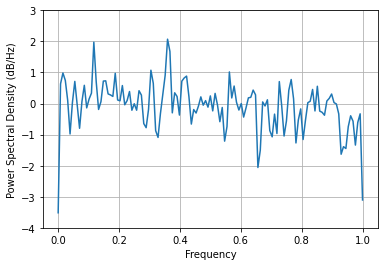

In [121]:
uu = np.random.standard_normal(10000)
plt.psd(uu)

In [7]:
(1+0.001)/2

0.5005